In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [17]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [10]:
NUM_CLASSES = 3
CHANNEL_SIZE = 5
BATCH_SIZE = 32
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [5]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

In [6]:
inputs, targets = generate_train_batch()

In [7]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

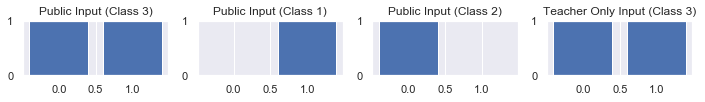

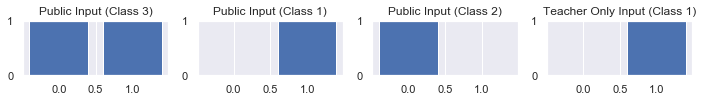

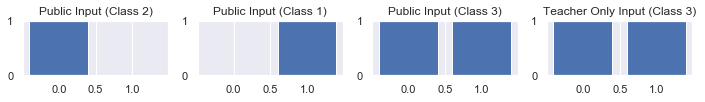

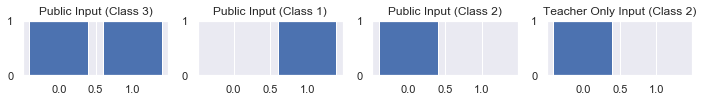

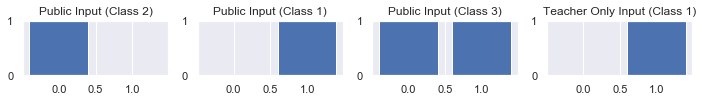

In [8]:
class_labels = list(TRAIN_DATA.keys())

if USE_MNIST:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for i, (ax, inp, tar) in enumerate(zip(axs, inputs, targets)):
        l = tar[row].numpy().argmax() + 1
        if i < NUM_CLASSES:
            ax.set_title(f'Public Input (Class {l})')
        else:
            ax.set_title(f'Teacher Only Input (Class {l})')
        if USE_MNIST:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [13]:
agent = Agent(CHANNEL_SIZE, NUM_CLASSES)
student = teacher = agent

inputs, targets = generate_train_batch()

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student,
                        training=True,
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0.5)

    loss = student_pred_matches_test_class(outputs, targets)

grads = tape.gradient(loss, agent.trainable_variables)

print('Mean Loss:', loss.numpy().mean())

print()

for v, g in zip(agent.trainable_variables, grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5 if g is not None else g}')

Mean Loss: 1.099984

agent/dense_2/kernel:0 teacher grad norm: 1.308613896369934
agent/dense_2/bias:0 teacher grad norm: 1.2225137948989868
agent/lstm_1/kernel:0 teacher grad norm: 2.533323287963867
agent/lstm_1/recurrent_kernel:0 teacher grad norm: 0.6613450050354004
agent/lstm_1/bias:0 teacher grad norm: 2.679287910461426
agent/dense_3/kernel:0 teacher grad norm: 1.1071875095367432
agent/dense_3/bias:0 teacher grad norm: 3.1013669967651367


In [14]:
agent.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate_1 (Concatenate)  multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
lambda_3 (Lambda)            multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  1664      
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
dense_3 (Dense)              multiple                  520       
_________________________________________________________________
lambda_4 (Lambda)            multiple                  0     

In [22]:
inputs, targets = generate_train_batch()
outputs = play_game(inputs, teacher, student,
                    p_mutate=1, 
                    channel_size=CHANNEL_SIZE,
                    kind_mutations=False,
                    training=False)

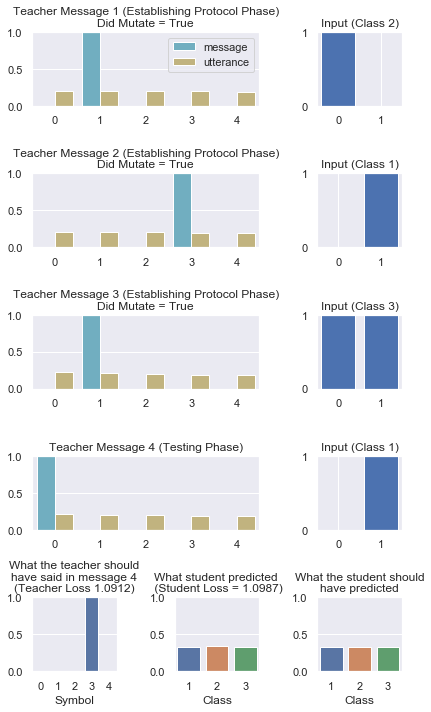

In [23]:
plot_game(inputs, outputs, targets, select_batch=6)

# Run Experiments

In [22]:
def create_vanilla_experiment(epochs=40, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0.0
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        **exp_kwargs
    )

In [23]:
baseline_meta_experiment = MetaExperiment(
    create_experiment_fn=create_vanilla_experiment,
    num_experiments=6,
    epochs=15,
    export_location='./experiments/baseline',
)

In [24]:
baseline_meta_experiment.run()

Running meta_experiment...
training_params_results
Test Loss: 0.0, Ground Truth F1-Score: 1.0, Student Error: 0.0, Teacher Error: 0.165, Protocol Diversity: 1.0, Protocol Entropy: 0.0,
vanilla_params_results
Test Loss: 0.0, Ground Truth F1-Score: 1.0, Student Error: 0.0, Teacher Error: 0.183, Protocol Diversity: 1.0, Protocol Entropy: 0.0,
training_params_results
Test Loss: 0.0, Ground Truth F1-Score: 1.0, Student Error: 0.0, Teacher Error: 0.056, Protocol Diversity: 1.0, Protocol Entropy: 0.0,
vanilla_params_results
Test Loss: 0.0, Ground Truth F1-Score: 1.0, Student Error: 0.0, Teacher Error: 0.054, Protocol Diversity: 1.0, Protocol Entropy: 0.0,
training_params_results
Test Loss: 0.0, Ground Truth F1-Score: 1.0, Student Error: 0.0, Teacher Error: 0.0, Protocol Diversity: 1.0, Protocol Entropy: 0.0,
vanilla_params_results
Test Loss: 0.0, Ground Truth F1-Score: 1.0, Student Error: 0.0, Teacher Error: 0.0, Protocol Diversity: 1.0, Protocol Entropy: 0.0,
training_params_results
Test Los

In [27]:
baseline_meta_experiment.results

[{'vanilla_params_test_metrics': [{'mean_test_loss': 13.245809555053711,
    'mean_ground_truth_f1': 0.0,
    'ground_truth_acc': 0.0,
    'mean_student_error': 13.245809555053711,
    'mean_teacher_error': 0.17878367006778717,
    'mean_protocol_diversity': 1.0,
    'mean_protocol_entropy': 7.222241883226942e-35},
   {'mean_test_loss': 15.550816535949707,
    'mean_ground_truth_f1': 0.0,
    'ground_truth_acc': 0.0,
    'mean_student_error': 15.550816535949707,
    'mean_teacher_error': 0.06229313462972641,
    'mean_protocol_diversity': 1.0,
    'mean_protocol_entropy': 7.222241883226942e-35}],
  'training_params_test_metrics': [{'mean_test_loss': 13.6746187210083,
    'mean_ground_truth_f1': 0.0,
    'ground_truth_acc': 0.0,
    'mean_student_error': 13.6746187210083,
    'mean_teacher_error': 0.2231781929731369,
    'mean_protocol_diversity': 1.0,
    'mean_protocol_entropy': 7.222241883226942e-35},
   {'mean_test_loss': 15.472737312316895,
    'mean_ground_truth_f1': 0.0,
    'gro

In [30]:
print('After training', len(baseline_meta_experiment.experiments), 'agents we ran', 
      2*len(baseline_meta_experiment.results), '"stranger-encounters"',
      'with the follow zero-shot coordination results:')
baseline_meta_experiment.print_results()

After training 6 agents we ran 30 "stranger-encounters" with the follow zero-shot coordination results:
meta_experiment results:  [0.0, 0.0, 0.10000000000000002, 0.0, 0.0, 0.36250000000000004, 0.68125, 0.44375, 0.6625, 0.69375, 1.0, 0.7125, 0.3375, 0.0, 0.36250000000000004, 0.19375, 0.3125, 0.0, 0.3125, 0.0, 0.59375, 0.69375, 0.65625, 0.5375, 0.4000000000000001, 0.20000000000000004, 0.35, 0.0, 1.0, 1.0]


In [31]:
zs_results = [
    metrics['mean_ground_truth_f1']
    for stranger_pairings in baseline_meta_experiment.results
    for metrics in stranger_pairings['vanilla_params_test_metrics']
]

print('Final mean zero-shot test performance: ', 
      round(float(np.mean(zs_results)), 4), '+-', 
      round(float(np.std(zs_results)), 4))

Final mean zero-shot test performance:  0.3869 +- 0.3212


In [29]:
for item in baseline_meta_experiment.experiments:
    if item['status'] == 'Complete':
        total_time = sum([
            x['seconds_taken']
            for x in item['experiment'].training_history
        ])
        print(int(total_time / 3600), 'hours,', int(total_time / 60), 'mins and', 
              int(total_time) % 60, 'seconds taken for experiment', item['index'])

0 hours, 2 mins and 14 seconds taken for experiment 0
0 hours, 2 mins and 17 seconds taken for experiment 1
0 hours, 2 mins and 16 seconds taken for experiment 2
0 hours, 2 mins and 10 seconds taken for experiment 3
0 hours, 2 mins and 9 seconds taken for experiment 4
0 hours, 2 mins and 21 seconds taken for experiment 5


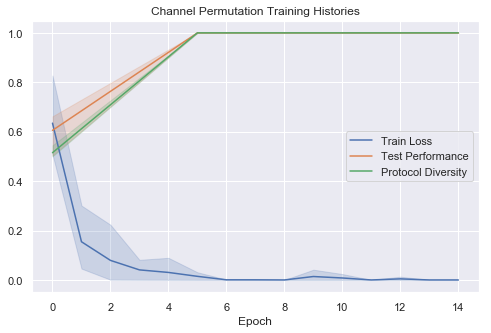

In [32]:
df_train = pd.DataFrame([
    {
        'Epoch': epoch,
        'Loss': train_item['loss'],
        'Experiment': f"Run {index}"
    }
    for index, item in enumerate(baseline_meta_experiment.experiments)
    for epoch, train_item in enumerate(item['experiment'].training_history)
])

df_test = pd.DataFrame([
    {
        'Epoch': epoch,
        'Performance': train_item['test_metrics']['mean_ground_truth_f1'],
        'Protocol Diversity': train_item['test_metrics']['mean_protocol_diversity'],
        'Experiment': f"Run {index}"
    }
    for index, item in enumerate(baseline_meta_experiment.experiments)
    for epoch, train_item in enumerate(item['experiment'].training_history)
    if 'test_metrics' in train_item
])


fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()
sns.lineplot(x='Epoch', y='Loss', data=df_train, label='Train Loss', ax=ax);
sns.lineplot(x='Epoch', y='Performance', data=df_test, label='Test Performance', ax=ax);
sns.lineplot(x='Epoch', y='Protocol Diversity', data=df_test, label='Protocol Diversity', ax=ax);
plt.ylabel('')
plt.title('Channel Permutation Training Histories')
plt.show()

In [33]:
experiment = baseline_meta_experiment.experiments[0]['experiment']
games_played, test_metrics = experiment.run_tests()
test_metrics

{'mean_test_loss': 1.1920928955078125e-07,
 'mean_ground_truth_f1': 1.0,
 'ground_truth_acc': 1.0,
 'mean_student_error': 1.1920928955078125e-07,
 'mean_teacher_error': 0.17936576902866364,
 'mean_protocol_diversity': 1.0,
 'mean_protocol_entropy': 7.222239013367687e-35}

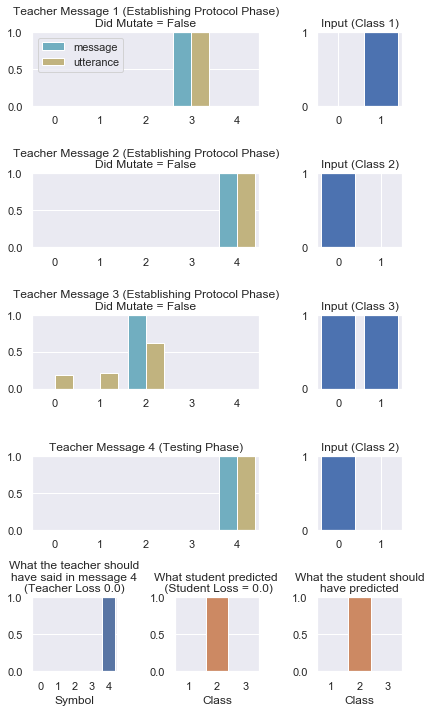

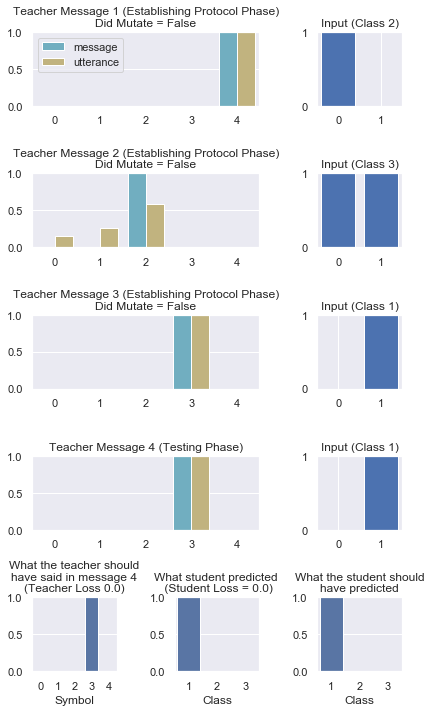

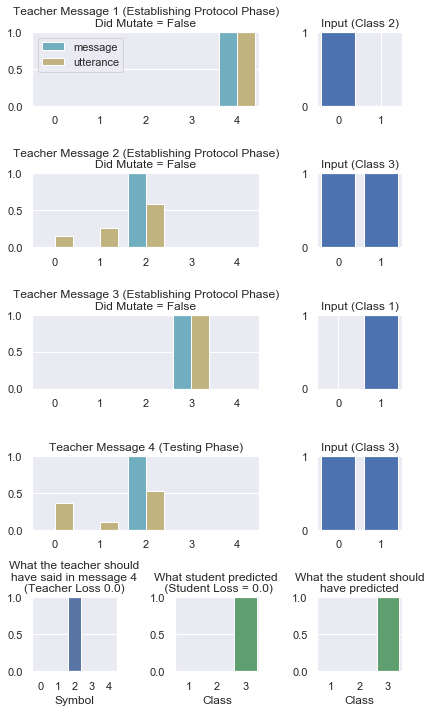

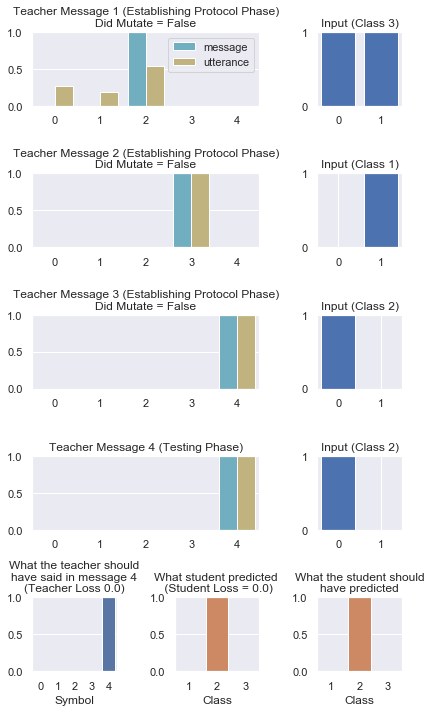

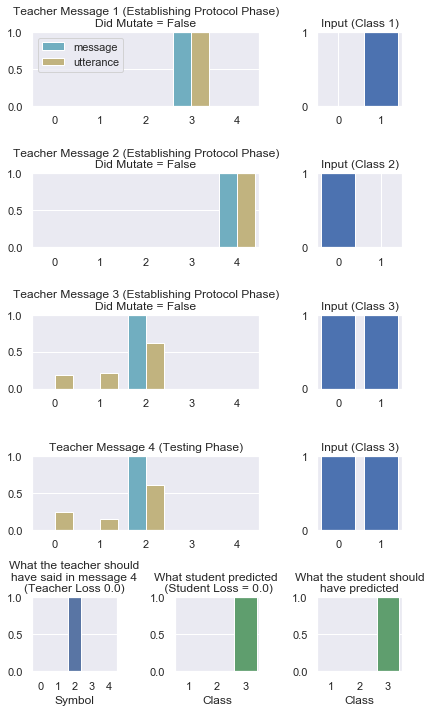

In [34]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

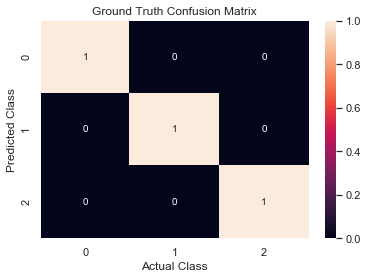

In [35]:
games_played, _ = experiment.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

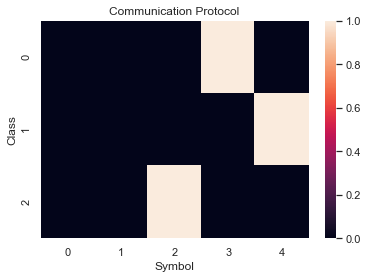

In [36]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

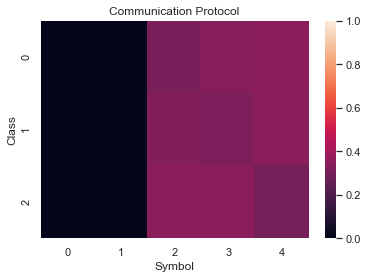

In [37]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_index_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()